In [625]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [626]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from GlucNet_functions import *

In [627]:
filepath = f"../OhioT1DM/2018/train/559-ws-training.xml"
tree = ET.parse(filepath)
root = tree.getroot()
glucose = read_ohio(filepath, "glucose_level", False)

# Preprocessing

#### P1

In [628]:
glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

# Create the multi-channel database
g_data = []
for timestamp in glucose_dict:
    record = {
        'timestamp': timestamp,
        'glucose_value': glucose_dict[timestamp],
        # 'meal_type': None,
        # 'meal_carbs': 0
    }
    
    g_data.append(record)
glucose_df = pd.DataFrame(g_data)

# Convert glucose values to numeric type for analysis
glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])

# Calculate percentiles
lower_percentile = np.percentile(glucose_df['glucose_value'], 2)
upper_percentile = np.percentile(glucose_df['glucose_value'], 98)

# Print thresholds
print(f"2% lower threshold: {lower_percentile}")
print(f"98% upper threshold: {upper_percentile}")

2% lower threshold: 64.0
98% upper threshold: 337.0


### P2, P3

In [629]:
segments = segement_data_as_1hour(glucose_df)
interpolated_segements = detect_missing_and_spline_interpolate(segments)

segment_3
before:  2021-12-12 04:54:00
after:  2021-12-12 05:29:00
segment_3
before:  2021-12-12 12:34:00
after:  2021-12-12 12:44:00
segment_3
before:  2021-12-12 22:09:00
after:  2021-12-12 22:39:00
segment_7
before:  2021-12-16 17:53:00
after:  2021-12-16 18:18:00
segment_14
before:  2021-12-22 17:52:00
after:  2021-12-22 18:52:00
segment_14
before:  2021-12-24 17:52:00
after:  2021-12-24 18:32:00
segment_15
before:  2021-12-26 18:57:00
after:  2021-12-26 19:22:00
segment_18
before:  2022-01-01 20:50:00
after:  2022-01-01 21:10:00
segment_21
before:  2022-01-06 06:26:00
after:  2022-01-06 07:21:00
segment_25
before:  2022-01-08 18:05:00
after:  2022-01-08 18:40:00
segment_29
before:  2022-01-14 01:05:00
after:  2022-01-14 01:35:00
segment_31
before:  2022-01-16 19:11:00
after:  2022-01-16 19:56:00


In [630]:
meal = read_ohio(filepath, "meal", False)

flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)

meal_df['assigned'] = False

meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '63' has dtype incompatible with int64, please explicitly cast to a

In [631]:
basal = read_ohio(filepath, "basal", False)

flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
basal_df = pd.DataFrame(flattened_basal_data)

basal_df['assigned'] = False
basal_df['end_ts'] = basal_df['ts'].shift(-1)
basal_df[:10]

,ts,value,assigned,end_ts
0,2021-12-07 00:00:00,0.65,False,2021-12-07 04:00:00
1,2021-12-07 04:00:00,0.73,False,2021-12-07 08:00:00
2,2021-12-07 08:00:00,1.15,False,2021-12-07 11:00:00
3,2021-12-07 11:00:00,0.9,False,2021-12-08 00:00:00
4,2021-12-08 00:00:00,0.65,False,2021-12-08 04:00:00
5,2021-12-08 04:00:00,0.73,False,2021-12-08 08:00:00
6,2021-12-08 08:00:00,1.15,False,2021-12-08 11:00:00
7,2021-12-08 11:00:00,0.9,False,2021-12-08 18:00:00
8,2021-12-08 18:00:00,1.25,False,2021-12-11 00:00:00
9,2021-12-11 00:00:00,0.65,False,2021-12-11 04:00:00


In [632]:
# basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)


In [633]:
# # Merge Bolus into the dataframe
# bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)

# flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist

# # Convert to DataFrame
# bolus_df = pd.DataFrame(flattened_bolus_data)

# bolus_df['assigned'] = False
# bolus_df[:10]

In [634]:
# bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)

In [635]:
# tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)

In [636]:
# flattened_tempbasal_data = [item[0] for item in tempbasal]  # Take the first (and only) item from each sublist

# # Convert to DataFrame
# tempbasal_df = pd.DataFrame(flattened_tempbasal_data)

# tempbasal_df['assigned'] = False
# tempbasal_df[:10]

In [637]:


# # Update the segments with meal data
# final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)

# Training

In [638]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [639]:
def label_delta_transform(labels_list):
    # label_lower_percentile = -12.75
    # label_upper_percentile = 12.85
    label_lower_percentile = np.percentile(labels_list, 10)
    label_upper_percentile = np.percentile(labels_list, 90)
    transformed_labels = []
    for label in labels_list:
        if label <= label_lower_percentile:
            transformed_labels.append(1)
        elif label_lower_percentile < label < label_upper_percentile:
            trans_label = round((256/(label_upper_percentile - label_lower_percentile))*(label + abs(label_lower_percentile) + 0.05))
            transformed_labels.append(trans_label)
        elif label >= label_upper_percentile:
            transformed_labels.append(256)
    return transformed_labels


# def prepare_dataset(segments, ph):
#     '''
#     ph = 6, 30 minutes ahead
#     ph = 12, 60 minutes ahead
#     '''
#     features_list = []
#     labels_list = []
#     raw_glu_list = []
    
#     # Iterate over each segment
#     for segment_name, segment_df in segments.items():
#         # Ensure all columns are of numeric type
#         segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
#         segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
#         segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

#         # Fill NaNs that might have been introduced by conversion errors
#         segment_df.fillna(0, inplace=True)

#         # Maximum index for creating a complete feature set
#         max_index = len(segment_df) - (15+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + 15 to exist
        
#         # Iterate through the data to create feature-label pairs
#         for i in range(max_index + 1):
#             # Extracting features from index i to i+15
#             features = segment_df.loc[i:i+15, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values#.flatten()
#             # Extracting label for index i+21
#             # Do the label transform
#             label = segment_df.loc[i+15+ph, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
#             raw_glu_list.append(segment_df.loc[i+15+ph, 'glucose_value'])
#             features_list.append(features)
#             labels_list.append(label)
            
#     print("len of features_list " + str(len(features_list)))
#     print("len of labels_list " + str(len(labels_list)))
#     new_labels_list = label_delta_transform(labels_list)    
#     print("after label transform. the len of label list "+str(len(new_labels_list)))    
#     return features_list, labels_list, new_labels_list, raw_glu_list

def prepare_dataset(segments, ph, history_len = 15):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
        segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
        segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        print("len of segment_df is ", len(segment_df))
        max_index = len(segment_df) - (history_len + ph)  # Subtracting only 15+ph to ensure i + 15 + ph is within bounds
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index):
            # Extracting features from index i to i+15
            segment_df = segment_df.reset_index(drop = True)
            features = segment_df.loc[i:i+history_len, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values
            # Extracting label for index i+15+ph
            # label = segment_df.loc[i+15+ph, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history_len+ph, 'glucose_value'])
            features_list.append(features)
            # labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    # print("len of labels_list " + str(len(labels_list)))
    
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform, the len of label list "+str(len(new_labels_list)))    
    
    return features_list, raw_glu_list


In [640]:
# load train data from the .pkl file
import pickle
file_num = 'all'
PH = 18
HISTORY = 15
with open(f'./BIG_training_data_all_wavenet.pkl', 'rb') as f:
    final_updated_segments= pickle.load(f)


features_list, labels_list = prepare_dataset(final_updated_segments, PH, HISTORY)

len of segment_df is  228
len of segment_df is  958
len of segment_df is  635
len of segment_df is  26
len of segment_df is  70
len of segment_df is  412
len of segment_df is  287
len of segment_df is  142
len of segment_df is  346
len of segment_df is  142
len of segment_df is  258
len of segment_df is  70
len of segment_df is  142
len of segment_df is  1161
len of segment_df is  272
len of segment_df is  70
len of segment_df is  1291
len of segment_df is  299
len of segment_df is  433
len of segment_df is  174
len of segment_df is  504
len of segment_df is  153
len of segment_df is  272
len of segment_df is  21
len of segment_df is  212
len of segment_df is  228
len of segment_df is  251
len of segment_df is  429
len of segment_df is  491
len of segment_df is  364
len of segment_df is  525
len of segment_df is  1650
len of segment_df is  1725
len of segment_df is  1726
len of segment_df is  224
len of segment_df is  573
len of segment_df is  631
len of segment_df is  202
len of segme

In [641]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)

# Step 1: Split into 80% train+val and 20% test
X_temp, X_test, y_temp, y_test = train_test_split(features_array, labels_array, test_size=0.2, shuffle=False)

# Step 2: Split the 80% into 70% train and 10% val (0.7/0.8 = 0.875)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, shuffle=False)

# Convert the splits to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [642]:
# Convert lists to PyTorch tensors
features_tensor = torch.tensor(features_list, dtype=torch.float32)
labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D

feature_label_tensor = TensorDataset(features_tensor, labels_tensor)


train_loader = DataLoader(feature_label_tensor, batch_size=32, shuffle=True)

# Example of using DataLoader in a training loop
for features, labels in train_loader:
    print("Features batch shape:", features.shape)
    print("Label batch shape:", labels.shape)
    # Example: print(features, labels)
    break

Features batch shape: torch.Size([32, 16, 4])
Label batch shape: torch.Size([32, 1])


In [643]:
# initialize cuda option
dtype = torch.FloatTensor # data type
ltype = torch.LongTensor # label type

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use gpu')
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

use gpu


In [644]:
# Build the dilate CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, dilation):
        super(WaveNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=1+dilation - 2^(dilation-1))
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=dilation)
        self.res_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        
    def forward(self, x):
        # print("shape of x: ", x.shape)
        out = F.relu(self.conv1(x))
        # print("shape of first out: ", out.shape)
        out = F.relu(self.conv2(out))
        # print("shape of second out: ", out.shape)
        res = self.res_conv(x)
        # print("shape of res: ", res.shape)
        return out + res

class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, dilations):
        super(WaveNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 32, kernel_size=2, padding=1)
        self.blocks = nn.ModuleList([WaveNetBlock(32, dilation) for dilation in dilations])
        self.final_conv1 = nn.Conv1d(32, 128, kernel_size=2, padding=0)
        self.final_conv2 = nn.Conv1d(128, 256, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        for block in self.blocks:
            # print("enter the block loop")
            x = block(x)
        x = F.relu(self.final_conv1(x))
        x = F.relu(self.final_conv2(x))
        x = x[:, :, -1]  # Get the last time step
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_channels = 4  # Number of features
output_channels = 1  # Predicting a single value (glucose level)
num_blocks = 4  # Number of WaveNet blocks
dilations = [2**i for i in range(num_blocks)]  # Dilation rates: 1, 2, 4, 8

model = WaveNet(input_channels, output_channels, num_blocks, dilations)

# Example of how to define the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)


In [645]:
for inputs, targets in train_loader:
    print("Input tensor shape:", inputs.shape)
    print("Input tensor total elements:", inputs.numel())
    print("Target tensor shape:", targets.shape)
    print("Sequence length:", inputs.shape[1])
    break


Input tensor shape: torch.Size([32, 16, 4])
Input tensor total elements: 2048
Target tensor shape: torch.Size([32, 1])
Sequence length: 16


In [646]:

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
        outputs = outputs.squeeze()  # Remove extra dimensions if present
        targets = targets.squeeze()  # Remove extra dimensions if present

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
            outputs = outputs.squeeze()  # Remove extra dimensions if present
            targets = targets.squeeze()  # Remove extra dimensions if present

            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

Epoch 1, Validation Loss: 1654.6798414633824
Epoch 2, Validation Loss: 1465.7516712042002
Epoch 3, Validation Loss: 1499.798139131986
Epoch 4, Validation Loss: 1500.1906914344202
Epoch 5, Validation Loss: 1654.955636537992
Epoch 6, Validation Loss: 1420.669142136207
Epoch 7, Validation Loss: 1518.5225284099579
Epoch 8, Validation Loss: 1489.02003799035
Epoch 9, Validation Loss: 1434.103958790119
Epoch 10, Validation Loss: 1447.6267334497893
Epoch 11, Validation Loss: 1678.8463446360367
Epoch 12, Validation Loss: 1773.8697740848247
Epoch 13, Validation Loss: 1361.4377967944513
Epoch 14, Validation Loss: 1383.6715010496287
Epoch 15, Validation Loss: 1411.6390510339004
Epoch 16, Validation Loss: 1383.3691954429332
Epoch 17, Validation Loss: 1375.5313351704524
Epoch 18, Validation Loss: 1344.7366355382478
Epoch 19, Validation Loss: 1424.1997400063735
Epoch 20, Validation Loss: 1362.0877864911006
Epoch 21, Validation Loss: 1399.5349672024067
Epoch 22, Validation Loss: 1282.422585414006
Epoc

In [656]:
# save model
torch.save(model, f'./glucnet_model_{file_num}_{PH}.pth')

In [657]:
def prepare_dataset_test_dataset( file_dir = f'../OhioT1DM/2018/test/559-ws-testing.xml', ph = 6):
        # test data
    g_data = []

    print("file_dir is ", file_dir)
    test_file_path = file_dir 
    test_glucose = read_ohio(test_file_path, "glucose_level", False)
    test_glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in test_glucose}

    for timestamp in test_glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': test_glucose_dict[timestamp],
        }
        
        g_data.append(record)
    test_glucose_df = pd.DataFrame(g_data)
    test_glucose_df['glucose_value'] = pd.to_numeric(test_glucose_df['glucose_value'])

    test_segmebts = segement_data_as_1hour(test_glucose_df)
    test_interpolated_segments = detect_missing_and_spline_interpolate(test_segmebts)

    test_meal = read_ohio(test_file_path, "meal", False)
    flattened_test_meal_data = [item[0] for item in test_meal]  # Take the first (and only) item from each sublist
    test_meal_df = pd.DataFrame(flattened_test_meal_data)
    test_meal_df['assigned'] = False
    test_meal_updated_segments = update_segments_with_meals(test_interpolated_segments, test_meal_df)

    test_basal = read_ohio(test_file_path, "basal", False)
    flattened_test_basal_data = [item[0] for item in test_basal]  # Take the first (and only) item from each sublist
    test_basal_df = pd.DataFrame(flattened_test_basal_data)
    test_basal_df['assigned'] = False
    test_basal_df['end_ts'] = test_basal_df['ts'].shift(-1)
    test_basal_updated_segments = update_segments_with_basal(test_meal_updated_segments, test_basal_df)

    test_bolus = read_ohio_bolus_tempbasal(test_file_path, "bolus", False)
    flattened_test_bolus_data = [item[0] for item in test_bolus]  # Take the first (and only) item from each sublist
    test_bolus_df = pd.DataFrame(flattened_test_bolus_data)
    test_bolus_df['assigned'] = False
    test_bolus_updated_segments = update_segments_with_bolus(test_basal_updated_segments, test_bolus_df)

    test_tempbasal = read_ohio_bolus_tempbasal(test_file_path, "temp_basal", False)
    flattened_test_tempbasal_data = [item[0] for item in test_tempbasal]  # Take the first (and only) item from each sublist
    test_tempbasal_df = pd.DataFrame(flattened_test_tempbasal_data)
    test_tempbasal_df['assigned'] = False

    test_final_updated_segments = update_segments_with_tempbasal(test_bolus_updated_segments, test_tempbasal_df)
    test_features_list, test_labels_list = prepare_dataset(test_final_updated_segments, ph)

    test_features_array = np.array(test_features_list)
    test_labels_array = np.array(test_labels_list)

    X_test, y_test = torch.tensor(test_features_array, dtype=torch.float32), torch.tensor(test_labels_array, dtype=torch.float32)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return test_loader



In [658]:
import glob

preds = []
trues = []
errors = []
fname = []

for file in glob.glob("../OhioT1DM/2018/test/*.xml"):
    test_filename = file
    test_loader = prepare_dataset_test_dataset(test_filename, PH)
    # Verify the content
    # Calculate RMSE on test set
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs.permute(0, 2, 1))
            predictions.append(outputs)
            actuals.append(targets)
            
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()

    rmse = np.sqrt(mean_squared_error(actuals,predictions))
    print(f'RMSE on test set: {rmse}')



    preds.append(predictions)
    trues.append(actuals)
    errors.append(rmse)
    fname.append(test_filename.split('-ws')[0][-3:])


file_dir is  ../OhioT1DM/2018/test\559-ws-testing.xml
segment_1
before:  2022-01-18 17:06:00
after:  2022-01-18 18:06:00
segment_3
before:  2022-01-21 16:32:00
after:  2022-01-21 16:47:00
segment_5
before:  2022-01-23 20:12:00
after:  2022-01-23 20:32:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '46' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a

len of segment_df is  499
len of segment_df is  239
len of segment_df is  367
len of segment_df is  162
len of segment_df is  510
len of segment_df is  283
len of segment_df is  142
len of segment_df is  96
len of segment_df is  232
len of features_list 2233
RMSE on test set: 45.005332946777344
file_dir is  ../OhioT1DM/2018/test\563-ws-testing.xml
segment_2
before:  2021-11-05 10:18:00
after:  2021-11-05 10:38:00
segment_2
before:  2021-11-06 03:38:00
after:  2021-11-06 03:48:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.5' has dtype incompatible with int64, please explicitly cast to 

len of segment_df is  848
len of segment_df is  1726
len of features_list 2508
RMSE on test set: 41.10233688354492
file_dir is  ../OhioT1DM/2018/test\570-ws-testing.xml
segment_1
before:  2022-01-17 06:39:00
after:  2022-01-17 06:59:00
segment_1
before:  2022-01-18 05:49:00
after:  2022-01-18 06:39:00
segment_2
before:  2022-01-21 17:09:00
after:  2022-01-21 18:04:00
segment_2
before:  2022-01-22 08:04:00
after:  2022-01-22 08:44:00
segment_2
before:  2022-01-23 06:44:00
after:  2022-01-23 07:29:00
segment_4
before:  2022-01-26 17:17:00
after:  2022-01-26 17:37:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '60' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '170' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '150' has dtype incompatible with int64, please explicitly cast to

Unequal: begin: 2022-01-17 07:23:45 end: 2022-01-17 07:53:45
Unequal: begin: 2022-01-17 12:04:02 end: 2022-01-17 12:34:02
Unequal: begin: 2022-01-17 19:45:45 end: 2022-01-17 20:45:45
Unequal: begin: 2022-01-18 07:14:27 end: 2022-01-18 07:44:27
Unequal: begin: 2022-01-18 12:09:25 end: 2022-01-18 12:39:25
Unequal: begin: 2022-01-18 19:06:47 end: 2022-01-18 19:36:47
Unequal: begin: 2022-01-19 07:03:53 end: 2022-01-19 07:33:53
Unequal: begin: 2022-01-19 11:44:39 end: 2022-01-19 12:14:39
Unequal: begin: 2022-01-19 16:43:34 end: 2022-01-19 17:13:34
Unequal: begin: 2022-01-19 19:13:28 end: 2022-01-19 19:43:28
Unequal: begin: 2022-01-20 07:00:39 end: 2022-01-20 07:30:39
Unequal: begin: 2022-01-20 11:57:00 end: 2022-01-20 12:27:00
Unequal: begin: 2022-01-20 14:40:03 end: 2022-01-20 15:10:03
Unequal: begin: 2022-01-20 18:29:00 end: 2022-01-20 18:59:00
Unequal: begin: 2022-01-21 06:12:20 end: 2022-01-21 06:42:20
Unequal: begin: 2022-01-21 20:15:04 end: 2022-01-21 21:15:04
Unequal: begin: 2022-01-

c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'bolus_dose'] = closest_bolus['dose']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:312: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.5' has dtype incompatible with int64, please explici

len of segment_df is  651
len of segment_df is  1550
len of segment_df is  69
len of segment_df is  515
len of features_list 2653
RMSE on test set: 42.47508239746094
file_dir is  ../OhioT1DM/2018/test\575-ws-testing.xml
segment_1
before:  2022-01-04 07:00:00
after:  2022-01-04 07:30:00
segment_2
before:  2022-01-05 19:25:00
after:  2022-01-05 19:45:00
segment_2
before:  2022-01-06 07:25:00
after:  2022-01-06 08:10:00
segment_3
before:  2022-01-07 19:35:00
after:  2022-01-07 20:05:00
segment_3
before:  2022-01-08 07:50:00
after:  2022-01-08 08:40:00
segment_4
before:  2022-01-09 06:44:00
after:  2022-01-09 07:29:00
segment_4
before:  2022-01-10 07:14:00
after:  2022-01-10 07:29:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '23' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '170' has dtype incompatible with int64, please explicitly cast to 

len of segment_df is  808
len of segment_df is  760
len of segment_df is  240
len of segment_df is  822
len of features_list 2498
RMSE on test set: 45.941307067871094
file_dir is  ../OhioT1DM/2018/test\588-ws-testing.xml


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '50' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a

len of segment_df is  401
len of segment_df is  1649
len of segment_df is  741
len of features_list 2692
RMSE on test set: 47.176082611083984
file_dir is  ../OhioT1DM/2018/test\591-ws-testing.xml
segment_2
before:  2022-01-20 05:29:00
after:  2022-01-20 05:44:00
segment_2
before:  2022-01-20 17:29:00
after:  2022-01-20 17:49:00


c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '57' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
c:\Users\Biratal\Desktop\Dartmouth\HealthX\ReproGenBG_ML4H\GluNet_Again\GlucNet_functions.py:421: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '41' has dtype incompatible with int64, please explicitly cast to a

len of segment_df is  388
len of segment_df is  1536
len of segment_df is  841
len of features_list 2666
RMSE on test set: 45.08096694946289


In [659]:
curr_dat = pd.DataFrame({'fname': fname, 'rmse': errors})
curr_dat.to_csv(f'wavenet_ph_{PH}_{file_num}.csv', index=False)

In [661]:
curr_dat

,fname,rmse
0,559,45.005333
1,563,41.102337
2,570,42.475082
3,575,45.941307
4,588,47.176083
5,591,45.080967


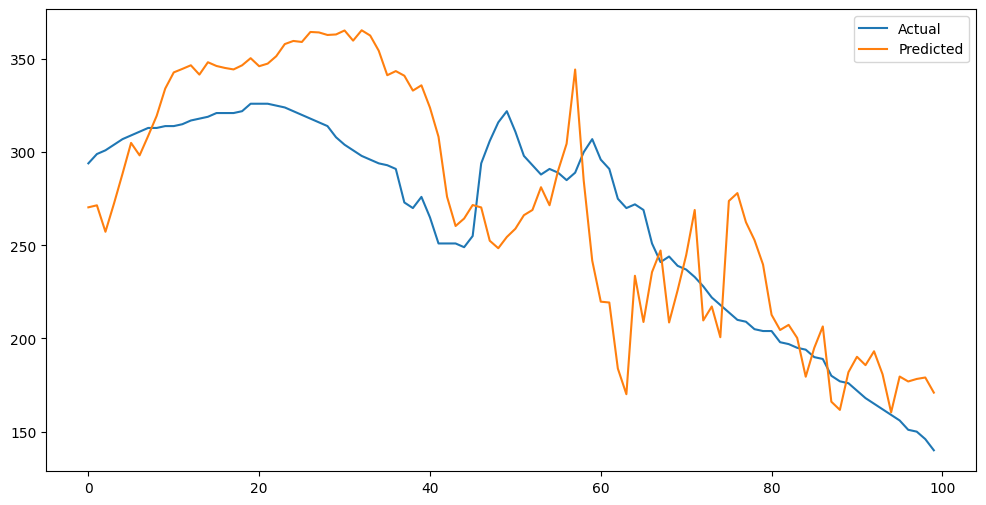

In [652]:
# plot the prediction
plt.figure(figsize=(12, 6))
plt.plot(trues[0][:100], label='Actual')
plt.plot(preds[0][:100], label='Predicted')
plt.legend()



In [653]:
# load all the data from the csv files
df_list = []
for file in glob.glob('./wavenet_ph_12*.csv'):
    temp = pd.read_csv(file)
    temp['trained on'] = file.split('_')[-1].split('.')[0]
    df_list.append(temp)
# combine all the data into one dataframe

df = pd.concat(df_list)
# pivot on trained on 
df = df.pivot(index='fname', columns='trained on', values='rmse') 
df

trained on,559,563,570,575,588,591
fname,,,,,,
559,36.410465,35.225582,33.402462,38.371143,39.093662,39.255234
563,40.276314,33.883686,30.473051,47.027763,39.698074,42.574295
570,40.084854,38.631165,27.280270,42.094067,38.522625,52.839590
575,40.853190,38.751957,36.972176,39.794506,38.433556,44.562910
588,37.908150,34.175060,32.602142,39.382870,33.703064,38.442844
591,42.047100,37.478480,36.900790,38.473194,39.823467,37.858353


In [654]:
# get the average of the columns
df['mean'] = df.mean(axis=0)

df['559'].mean()

39.596678833333335